# Object Detection using YOLOX with OpenVINO™

Welcome to this tutorial notebook that demonstrates the use of YOLOX with OpenVINO. YOLOX is a state-of-the-art object detection algorithm that achieves excellent accuracy while maintaining real-time performance. OpenVINO, on the other hand, is a powerful toolkit that optimizes the inference of deep learning models on a wide range of hardware platforms.

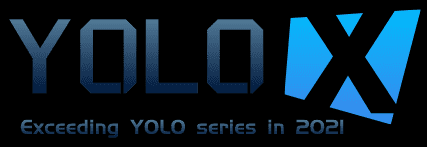

By combining the strengths of YOLOX and OpenVINO, you can get the best of both worlds: highly accurate object detection with lightning-fast inference on a variety of hardware devices. This tutorial will guide you through the process of using YOLOX with OpenVINO to detect objects in images and videos.

Whether you are a computer vision researcher, an engineer working on a product that requires object detection, or just an enthusiast interested in learning about the latest and greatest in computer vision, this tutorial will provide you with a solid foundation to get started with YOLOX and OpenVINO. So let's dive in and explore the exciting world of object detection with YOLOX and OpenVINO!


YOLOX Paper Link: https://arxiv.org/abs/2107.08430  \
YOLOx Repository: https://github.com/Megvii-BaseDetection/YOLOX

To give a overview of the notebook, the major sections of this notebook are:
* Adding Google Colab Support
* Converting Model to use with OpenVino
* Inference with YOLOX using OpenVino
* Validation on COCO 2017 dataset

Lets Start!

# Adding Google Colab Support

Uncomment & Run this cell if you are running on Google Colab, or at any environment other than within the repository.

In [37]:
import os
from glob import glob
from IPython.core.getipython import get_ipython

# Checking if running in Google Colab
IN_COLAB = 'google.colab' in str(get_ipython())

# Clone, Install dependecies and Change Directory if running in Google Colab
if IN_COLAB:
    ! pip install openvino-dev -q
    !git clone -b yolox-notebook https://github.com/sawradip/openvino_notebooks.git
    notebook_dir = glob("openvino_notebooks/notebooks/*-yolox-object-detection")[0]
    os.chdir(notebook_dir)

Cloning into 'openvino_notebooks'...
remote: Enumerating objects: 4492, done.
remote: Counting objects: 100% (4490/4490), done.
remote: Compressing objects: 100% (1679/1679), done.
remote: Total 4492 (delta 2709), reused 4489 (delta 2709), pack-reused 2
Receiving objects: 100% (4492/4492), 301.05 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (2709/2709), done.
Updating files: 100% (326/326), done.


Here we are importing some utility functions imported inside `openvino-notebooks` repository.

In [38]:
import sys 
sys.path.insert(0, "../utils")
import notebook_utils

# Getting the YOLOX repository

Here, we are downloading and installing the `YOLOX` repository so that we can install the implemented function and models.


In [39]:
from pathlib import Path

# Cloning the YOLOX repository if not already present
if not Path('YOLOX').exists():
    ! git clone https://github.com/Megvii-BaseDetection/YOLOX.git

# Changing Directory
os.chdir('YOLOX')

# Installing YOLOX in edit mote
! pip install -q -e .

Cloning into 'YOLOX'...
remote: Enumerating objects: 1880, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1880 (delta 34), reused 47 (delta 13), pack-reused 1782
Receiving objects: 100% (1880/1880), 7.54 MiB | 15.14 MiB/s, done.
Resolving deltas: 100% (1099/1099), done.
  Preparing metadata (setup.py) ... done


# Converting Model to use with Openvino

In this section, we our going to convert a trained `yolox` model to `xml/bin` format that is specialized, easy to use and optimize for openvino.

In [40]:
# Import Libraries
import cv2
import yaml
import torch
from torch import nn
import numpy as np
from tqdm.notebook import tqdm
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
from openvino.runtime import Model
from collections import namedtuple

%matplotlib inline

from yolox.exp import get_exp
from yolox.utils import replace_module
from yolox.models.network_blocks import SiLU


**Note**: The official `YOLOX` repository contains converted version of all the models, which can be used directly. To download the ONNX version of a model, please copy the download link from this `weights table` and use it in the next cell(uncommenting it) to initiate the download process.

| Model | Parameters | GFLOPs | Test Size | mAP | ONNX Weights |
|:------| :----: | :----: | :---: | :---: | :---: |
|  yolox_nano |  0.91M  | 1.08 | 416x416 | 25.8 |[github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_nano.onnx) |
|  yolox_tiny | 5.06M     | 6.45 | 416x416 |32.8 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_tiny.onnx) |
|  yolox_s | 9.0M | 26.8 | 640x640 |40.5 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_s.onnx) |
|  yolox_m | 25.3M | 73.8 | 640x640 |47.2 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_m.onnx) |
|  yolox_l | 54.2M | 155.6 | 640x640 |50.1 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_l.onnx) |
|  yolox_darknet| 63.72M | 185.3 | 640x640 |48.0 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_darknet.onnx) |
|  yolox_x | 99.1M | 281.9 | 640x640 |51.5 | [github](https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_x.onnx) |


However, in order to use with any `yolox` model, we going to convert a `yolox_tiny` model from scratch.

You can use this code with any other `yolox` models , just by changing the variable `model_name` with any model from the `weights table`.

In [41]:
# Set the model name you want to work on
model_name = 'yolox_nano'

Loading the `exp` opbject containing the model and related information for selected `model_name` model.

In [42]:
# Load experiment configuration file
exp = get_exp(exp_file=f"exps/default/{model_name}.py")

# Printing the model information
print(exp)

╒═══════════════════╤════════════════════════════╕
│ keys              │ values                     │
╞═══════════════════╪════════════════════════════╡
│ seed              │ None                       │
├───────────────────┼────────────────────────────┤
│ output_dir        │ './YOLOX_outputs'          │
├───────────────────┼────────────────────────────┤
│ print_interval    │ 10                         │
├───────────────────┼────────────────────────────┤
│ eval_interval     │ 10                         │
├───────────────────┼────────────────────────────┤
│ dataset           │ None                       │
├───────────────────┼────────────────────────────┤
│ num_classes       │ 80                         │
├───────────────────┼────────────────────────────┤
│ depth             │ 0.33                       │
├───────────────────┼────────────────────────────┤
│ width             │ 0.25                       │
├───────────────────┼────────────────────────────┤
│ act               │ 'silu'   

Lets download the pretreined weight for the selected `yolox` model. 

If you want to use the weight of your trained model, replace the checkpoint_file path.

In [43]:

# Weight url
ckpt_url = f"https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/{model_name}.pth"

# Downloading
ckpt_file = notebook_utils.download_file(ckpt_url)

yolox_nano.pth:   0%|          | 0.00/7.34M [00:00<?, ?B/s]

Next, we are going to export the model to `onnx` format(PyTorch built-in `onnx.export`), and then convert to OpenVino's optimized `xml` format(OpenVino's `convert` and `serialize` model). 


Lets set up some parameters, necessary for model conversion.

In [44]:
# Define the path to the experiment configuration file
exp_file = f"exps/default/{model_name}.py"

# Define the name for the output ONNX file
output_name = f'my_{model_name}.onnx'

# Define input & output node name
input_node = "images"
output_node = "output"

# Define the batch size for inference
batch_size = 1

# Set the ONNX opset version
opset = 11

This code block loads a YOLOX model from a checkpoint file, replaces a specific activation function in the model, and then exports the model to the ONNX format.

In [45]:
# Instantiate model
model = exp.get_model()

# Load model weights from checkpoint
ckpt = torch.load(ckpt_file, map_location="cpu")
model.eval()
if "model" in ckpt:
    ckpt = ckpt["model"]
model.load_state_dict(ckpt)

# Replace nn.SiLU with custom SiLU activation function
model = replace_module(model, nn.SiLU, SiLU)

# Set decode_in_inference flag of model head
model.head.decode_in_inference = False

# Print message indicating checkpoint loading is complete
print("loading checkpoint done.")

# Create dummy input tensor for exporting to ONNX format
dummy_input = torch.randn(batch_size, 3, exp.test_size[0], exp.test_size[1])

# Export model to ONNX format
torch.onnx.export(model, dummy_input, output_name,
                  input_names=[input_node],
                  output_names=[output_node],
                  opset_version=opset,
)

# Print message indicating ONNX export is complete
print("ONNX conversion done: {}".format(output_name))

loading checkpoint done.
ONNX conversion done: my_yolox_nano.onnx


OpenVINO XML format is a standardized file format for representing neural network models optimized for use with Intel hardware.

It is a part of the OpenVINO toolkit which is designed to accelerate neural network inference on Intel platforms.
The XML format is optimized for high-performance inference on CPUs and other Intel hardware, making it suitable for deployment in a range of scenarios.

Here, the `serialize` function is used to serialize an OpenVINO IR model that has been converted from the YOLOX model using the Model Optimizer (MO) tool, and save it to an XML file. The resulting XML file can be loaded into the OpenVINO Inference Engine for deployment on an Intel hardware platform.

**Note:** Both the `.xml` and `.bin` files will be saved at the given destination.

In [46]:
from openvino.tools import mo
from openvino.runtime import serialize

# Convert the ONNX model to OpenVINO Intermediate Representation (IR) format
model = mo.convert_model(f'my_{model_name}.onnx')

# Serialize and save the converted IR model to the specified path
serialize(model=model, xml_path=f'vino/{model_name}.xml')

# Inference with YOLOX using OpenVino

Here, we are loading and viewing the image we are going to test on.

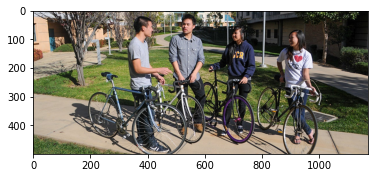

In [47]:
# Load the image and visulize
input_path = "../input.jpg"
image = notebook_utils.load_image(input_path)
plt.imshow(image[:, :, ::-1])

Name of the 80 different classed this model is trained on.

In [48]:
# A list of class names
COCO_CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
                'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 
                'kite', 'baseball bat', 'baseball glove', 'skateboard', 
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 
                'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 
                'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 
                'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
                'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
                'refrigerator', 'book', 'clock', 'vase', 'scissors', 
                'teddy bear', 'hair drier', 'toothbrush')

# Checking number of classes
print(len(COCO_CLASSES))

80


Loading a list of 80 different Colors for Bounding boxes of each class.

In [49]:
# Loading an np.array of colors
_COLORS = np.load('../colors.npy')

# Checking the shape
print(_COLORS.shape)

(80, 3)


## These are some utility functions necessary for the inference process

In [50]:
def preprocess(img, input_size, swap=(2, 0, 1)):
    """
    Preprocesses an image by resizing and padding it to a specific input size, and converting it to a float32 NumPy array.

    :param numpy.ndarray img: The image to preprocess.
    :param tuple input_size: A tuple of two integers representing the desired input size.
    :param tuple swap: (optional) A tuple of three integers representing the desired order of color channels. Defaults to (2, 0, 1).

    :return: The preprocessed image as a float32 NumPy array and the scaling ratio of the image as a float.
    :rtype: Tuple[numpy.ndarray, float]

    """

    # Check if image has 3 dimensions, otherwise pad it with 114
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3),
                             dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    # Resize the image and calculate the scaling ratio
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)

    # Copy the resized image into the padded image array
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    # Swap the color channels and convert the padded image array to a float32
    # NumPy array
    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


def nms(boxes, scores, nms_thr):
    """
    Apply Non-Maximum Suppression (NMS) to a set of bounding boxes, removing
    those that overlap with higher-scoring boxes.

    :param boxes: Numpy array of shape (num_boxes, 4), containing the coordinates of
                each bounding box in (x1, y1, x2, y2) format.
    :type boxes: numpy.ndarray
    :param scores: Numpy array of shape (num_boxes,), containing the confidence scores
                of each bounding box.
    :type scores: numpy.ndarray
    :param nms_thr: Float specifying the threshold for overlap between bounding boxes,
                    above which the lower-scoring box will be removed.
    :type nms_thr: float

    :returns: List of indices corresponding to the bounding boxes that were
            retained after NMS.
    :rtype: list
    """
    # Extract coordinates of bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Calculate area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort scores in descending order and get corresponding indices
    order = scores.argsort()[::-1]

    # Initialize list to store indices of boxes to keep
    keep = []

    # Loop over all boxes
    while order.size > 0:
        # Select box with highest score
        i = order[0]
        keep.append(i)

        # Calculate intersection between selected box and all other boxes
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # Calculate overlap between selected box and all other boxes
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        # Keep only boxes with overlap less than NMS threshold
        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]

    return keep


def multiclass_nms(boxes, scores, nms_thr, score_thr, class_agnostic=True):
    """
    Apply non-maximum suppression (NMS) on boxes according to their intersection-over-union (IoU) overlap and class scores.

    :param boxes: A numpy array of shape (N, 4) where N is the number of bounding boxes, and the last dimension represents (x1, y1, x2, y2) of each bounding box.
    :type boxes: numpy.ndarray
    :param scores: A numpy array of shape (N, C) where N is the number of bounding boxes, and C is the number of classes. Each element represents the score of each bounding box for each class.
    :type scores: numpy.ndarray
    :param nms_thr: The IoU threshold used in non-maximum suppression.
    :type nms_thr: float
    :param score_thr: The threshold used to filter out bounding boxes with scores lower than this value.
    :type score_thr: float
    :param class_agnostic: Whether to use class-agnostic NMS or class-aware NMS. If True, class-agnostic NMS is used.
    :type class_agnostic: bool

    :return: A numpy array of shape (M, 6) where M is the number of final detections after NMS, and the last dimension represents (x1, y1, x2, y2, score, class) of each detection.
    :rtype: numpy.ndarray
    """
    # Choose NMS method
    if class_agnostic:
        nms_method = multiclass_nms_class_agnostic
    else:
        nms_method = multiclass_nms_class_aware

    # Apply NMS
    return nms_method(boxes, scores, nms_thr, score_thr)


def multiclass_nms_class_aware(boxes, scores, nms_thr, score_thr):
    """
    The function performs class aware non-maximum suppression.
    Given bounding boxes and their corresponding scores,
    the function applies non-maximum suppression (NMS) to discard
    overlapping bounding boxes. Only bounding boxes with scores above
    `score_thr` are considered.

    :param boxes: A numpy array of shape (N, 4) where N is the number of
        bounding boxes, and the last dimension represents (x1, y1, x2, y2) of
        each bounding box.
    :type boxes: numpy.ndarray

    :param scores: A numpy array of shape (N, C) where N is the number of
        bounding boxes, and C is the number of classes. Each element represents
        the score of each bounding box for each class.
    :type scores: numpy.ndarray

    :param nms_thr: The IoU threshold used in non-maximum suppression.
    :type nms_thr: float

    :param score_thr: The threshold used to filter out bounding boxes with
        scores lower than this value.
    :type score_thr: float

    :return: A numpy array of shape (M, 6) where M is the number of final
        detections after NMS, and the last dimension represents (x1, y1, x2, y2,
        score, class) of each detection.
    :rtype: numpy.ndarray
    """

    final_dets = []
    num_classes = scores.shape[1]

    # Iterate over all classes
    for cls_ind in range(num_classes):
        cls_scores = scores[:, cls_ind]
        valid_score_mask = cls_scores > score_thr

        # If no bounding boxes have score above the threshold for this class,
        # skip to the next class
        if valid_score_mask.sum() == 0:
            continue

        # Otherwise, select the valid bounding boxes and their scores
        else:
            valid_scores = cls_scores[valid_score_mask]
            valid_boxes = boxes[valid_score_mask]

            # Apply NMS on the selected bounding boxes
            keep = nms(valid_boxes, valid_scores, nms_thr)
            if len(keep) > 0:
                cls_inds = np.ones((len(keep), 1)) * cls_ind
                dets = np.concatenate(
                    [valid_boxes[keep], valid_scores[keep, None], cls_inds], 1
                )
                final_dets.append(dets)

    # If there are no detections, return None
    if len(final_dets) == 0:
        return None

    # Concatenate the final detections from all classes into a single numpy
    # array
    return np.concatenate(final_dets, 0)


def multiclass_nms_class_agnostic(boxes, scores, nms_thr, score_thr):
    """ 
    The function performs class-agnostic non-maximum suppression.
    Given bounding boxes and their corresponding scores, the function applies
    non-maximum suppression (NMS) to discard overlapping bounding boxes. Only
    bounding boxes with scores above `score_thr` are considered.

    :param boxes: A numpy array of shape (N, 4) where N is the number
                of bounding boxes, and the last dimension
                represents (x1, y1, x2, y2) of each bounding box.
    :type boxes: numpy.ndarray
    :param scores: A numpy array of shape (N,) containing the
                confidence scores of each bounding box.
    :type scores: numpy.ndarray
    :param nms_thr: The IoU threshold used in non-maximum suppression.
    :type nms_thr: float
    :param score_thr: The threshold used to filter out bounding boxes with
                    scores lower than this value.
    :type score_thr: float

    :return: A numpy array of shape (M, 5) where M is the number of
            final detections after NMS, and the last dimension
            represents (x1, y1, x2, y2, score) of each detection.
    :rtype: numpy.ndarray
    """
    # Get the index of the highest scoring class for each box.
    cls_inds = scores.argmax(1)

    # Get the score for the highest scoring class for each box.
    cls_scores = scores[np.arange(len(cls_inds)), cls_inds]

    # Create a mask to select boxes that have scores greater than the
    # threshold.
    valid_score_mask = cls_scores > score_thr

    # If there are no boxes that pass the score threshold, return None.
    if valid_score_mask.sum() == 0:
        return None

    # Select the scores, boxes, and class indices for the boxes that pass
    # the score threshold.
    valid_scores = cls_scores[valid_score_mask]
    valid_boxes = boxes[valid_score_mask]
    valid_cls_inds = cls_inds[valid_score_mask]

    # Apply non-maximum suppression to the selected boxes and scores.
    keep = nms(valid_boxes, valid_scores, nms_thr)

    # If there are no boxes that survive non-maximum suppression, return None.
    if keep:
        # Combine the selected boxes, scores, and class indices into a single
        # array.
        dets = np.concatenate(
            [valid_boxes[keep], valid_scores[keep, None],
             valid_cls_inds[keep, None]], 1
        )
    return dets


def demo_postprocess(outputs, img_size, p6=False):
    """
    Postprocesses the output of the YOLOX model for object detection.

    :param outputs: The output of the YOLOv5 model.
    :type outputs: ndarray
    :param img_size: A tuple containing the height and width of the input image.
    :type img_size: tuple
    :param p6: A flag indicating whether to use the P6 output from the model. Defaults to False.
    :type p6: bool, optional

    :returns: The post-processed output of the YOLOv5 model for object detection.
    :rtype: ndarray
    """

    # Create empty lists to hold the grid and expanded stride values for
    # each scale
    grids = []
    expanded_strides = []

    # Define the strides for each scale
    strides = [8, 16, 32] if not p6 else [8, 16, 32, 64]

    # Calculate the height and width of the feature maps for each scale
    hsizes = [img_size[0] // stride for stride in strides]
    wsizes = [img_size[1] // stride for stride in strides]

    # Create the grid and expanded stride values for each scale
    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    # Concatenate the grid and expanded stride values for each scale
    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)

    # Apply the final post-processing steps to the model output
    outputs[..., :2] = (outputs[..., :2] + grids) * expanded_strides
    outputs[..., 2:4] = np.exp(outputs[..., 2:4]) * expanded_strides

    # Return the post-processed output
    return outputs


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements.

    :param image: Numpy array of shape (height, width, channels) with uint8 data in [0, 255] range.
    :type image: numpy.ndarray

    :return: Torch tensor object of shape (channels, height, width) with float data in [0, 1] range.
    :rtype: torch.Tensor
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    # input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor
    

def vis(img, boxes, scores, cls_ids, conf=0.5, class_names=None):
    """
    Visualize detection results on an image.

    :param img: An input image.
    :type img: ndarray
    :param boxes: An array of bounding boxes in format (x0, y0, x1, y1).
    :type boxes: ndarray
    :param scores: An array of detection scores.
    :type scores: ndarray
    :param cls_ids: An array of class IDs.
    :type cls_ids: ndarray
    :param conf: Confidence threshold to filter out low confidence detections. Defaults to 0.5.
    :type conf: float
    :param class_names: A list of class names. If None, class IDs will be used instead.
    :type class_names: list or None

    :returns: An annotated image with bounding boxes, class labels and scores.
    :rtype: ndarray
    """

    # Loop through each bounding box and its corresponding class ID and score
    for i in range(len(boxes)):

        # Get the current bounding box, class ID, and score
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]

        # If the score is below the confidence threshold, skip this box
        if score < conf:
            continue

        # Extract the coordinates of the bounding box
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        # Get color for the box border from a pre-defined color palette
        color = (_COLORS[cls_id] * 255).astype(np.uint8).tolist()

        # Construct the label text and get text color based on the box border
        # color
        text = '{}:{:.1f}%'.format(class_names[cls_id], score * 100)
        if np.mean(_COLORS[cls_id]) > 0.5:
            txt_color = (0, 0, 0)
        else:
            txt_color = (255, 255, 255)

        # Set the font for the label text and get the size
        font = cv2.FONT_HERSHEY_SIMPLEX
        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]

        # Draw the bounding box and label on the image
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)

        txt_bk_color = (_COLORS[cls_id] * 255 * 0.7).astype(np.uint8).tolist()
        cv2.rectangle(
            img=img,
            pt1=(x0, y0 + 1),
            pt2=(x0 + txt_size[0] + 1, y0 + int(1.5 * txt_size[1])),
            color=txt_bk_color,
            thickness=-1
        )
        # Draw the text label on the image
        cv2.putText(img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color,
                    thickness=1)

    return img

# Openvino Workflow



This cell initializes an instance of the Inference Engine Core using the `Core` class from the OpenVINO toolkit. The inference engine core is a runtime engine that provides a unified API for running pre-trained deep learning models on various hardware devices such as CPU, GPU, VPU, and FPGA. 

The `Core` class is the central class that provides a simple and unified way to load and run deep learning models using the Inference Engine. It is a fundamental class to work with the Inference Engine and is required to load the models into the memory and run the inference.

In [51]:
# Step 1. Initialize inference engine core
import openvino.runtime as ov
core = ov.Core()

In this step, the inference engine core reads the model in OpenVINO Intermediate Representation or ONNX format. The `read_model()` function of the `Core` object is used for this purpose. The function takes a single argument model, which is the path to the ONNX file containing the model.

The `read_model()` function returns a network object, which represents the topology of the model. This object can be used to perform inference on input data.

In [52]:
# Step 2. Read a model in OpenVINO Intermediate Representation or ONNX
# format
model = core.read_model(model=f'vino/{model_name}.xml')

This step reads the model in either OpenVINO IR format or `ONNX format`. 


This step loads the model onto the specified `device`. The device is specified as a string in the device variable, which is set to `CPU` in this case. The `compile_model()` method of the ie object is called to compile the model on the specified device. The method takes in two arguments: `model` which is the network to be loaded, and `device_name`, which is the device on which to load the network.

In [53]:
# Step 3. Loading model to the device

device = 'CPU'
exec_net = core.compile_model(model=model, device_name=device)

Overall, these steps set the groundwork for loading a neural network model, configuring it for optimal performance, and defining the input/output layer information.

This cell block creates an inference request and prepares the input image for inference by resizing and processing it. It uses OpenVINO Inference Engine to run the inference.

In [54]:
# Step 4. Prepare input

# Load the image from input_path using the helper function
origin_img = notebook_utils.load_image(input_path)

# Get the shape of the input tensor required by the model
_, _, h, w = exec_net.inputs[0].shape

# Preprocess the input image by resizing it to the required shape,
# and normalizing its pixel values. Also, return the ratio by which
# the image was resized, as we will use it to rescale the predicted
# boxes
image, ratio = preprocess(origin_img, (h, w))

# Convert the preprocessed input image to a tensor, and prepare it for inference by reshaping it
# and transposing its dimensions to match the expected input tensor shape
prepared_img = prepare_input_tensor(image)

# Printing shpae of the prepared image
print(image.shape)

(3, 416, 416)


This step is doing the inference of the input image using the Executable Network instance created in Step 3. 

It takes the preprocessed image as input and returns a dictionary containing the inference results. Then we are reading the value from the dictionary using key `output_blob`.

In [55]:
# Step 5. Do inference

output_blob = exec_net.output(0)
res = exec_net(prepared_img)[output_blob]

This block of code takes the output of the infer request and processes it to produce the final detection results. It performs non-maximum suppression and visualizes the detected objects with bounding boxes and class labels on the input image.

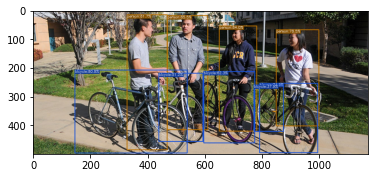

In [56]:
# Step 6. Process output

# Set a threshold for score confidence
score_thr = 0.3

# Set the path for output image
output_path = "test.jpg"

# Extract results from the model's output blob
# res = res[out_blob]

# Post-process the output to get predictions
predictions = demo_postprocess(res, (h, w))[0]

# Extract bounding boxes and scores from the predictions
boxes = predictions[:, :4]
scores = predictions[:, 4, None] * predictions[:, 5:]

# Convert the bounding boxes from (x_center, y_center, width, height)
# to (x1, y1, x2, y2) format
boxes_xyxy = np.ones_like(boxes)
boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2.
boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2.
boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2.
boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2.

# Convert the bounding box coordinates to the original image size
boxes_xyxy /= ratio

# Apply Non-Maximum Suppression (NMS) to get the final detections
dets = multiclass_nms(boxes=boxes_xyxy, scores=scores,
                      nms_thr=0.45, score_thr=0.1)


# If there are any detections above the confidence threshold
if dets is not None:

    # Get the final bounding boxes, scores, and class indices
    final_boxes = dets[:, :4]
    final_scores, final_cls_inds = dets[:, 4], dets[:, 5]

    # Visualize the bounding boxes on the original image
    detecetd_img = vis(img=origin_img, boxes=final_boxes,
                       scores=final_scores, cls_ids=final_cls_inds,
                       conf=score_thr, class_names=COCO_CLASSES)

# Save the image with bounding boxes drawn on it
cv2.imwrite(output_path, detecetd_img)

plt.imshow(detecetd_img[:, :, ::-1])

# Validation on COCO 2017 dataset

In this section, we are going to test the preformance of the model inference using OpenVino.

**Note:** For the purpose of validation, we are going to use some utility functions implemented in [YOLOV7](https://github.com/WongKinYiu/yolov7) repository.

Lets clone the repository.

In [57]:
# Going back to base directory
os.chdir('..')

# Clone if yolov7 repository is not already present
if not Path('yolov7').exists():
    ! git clone https://github.com/WongKinYiu/yolov7
    
os.chdir('yolov7')

Cloning into 'yolov7'...
remote: Enumerating objects: 1130, done.
remote: Total 1130 (delta 0), reused 0 (delta 0), pack-reused 1130
Receiving objects: 100% (1130/1130), 69.94 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (520/520), done.


Here are some necessary imports for the Validation, some are obtained from `yolov7` repository.

In [58]:
from utils.datasets import create_dataloader
from utils.metrics import ap_per_class
from utils.general import check_dataset, box_iou, xywh2xyxy, colorstr

We are going to use `COCO VAL2017` data for validation. The annotations we use are obtained from `ultralutics/yolov5` project.

In [59]:
from zipfile import ZipFile

# Set URLs for the COCO dataset and labels
DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

# Set the output directory
OUT_DIR = Path('.')

# Download and extract the COCO dataset and labels
notebook_utils.download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
notebook_utils.download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)


# If the "labels" folder does not exist in the output directory, extract the 
# COCO labels and the validation dataset images
if not (OUT_DIR / "coco/labels").exists():

    # Extract the labels zip file
    with ZipFile('coco2017labels-segments.zip', "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)

    # Extract the validation dataset images zip file
    with ZipFile('val2017.zip', "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

coco2017labels-segments.zip:   0%|          | 0.00/169M [00:00<?, ?B/s]

In [60]:
# Read dataset config
DATA_CONFIG = 'data/coco.yaml'
with open(DATA_CONFIG) as f:
    data = yaml.load(stream=f, Loader=yaml.SafeLoader)

# Set input shape
_, _, _, hw = exec_net.inputs[0].shape

# Set task and options
TASK = 'val'

# Imitation of CLI provided options for Single Class Evaluation
Option = namedtuple('Options', ['single_cls'])
opt = Option(False)

# Create dataloader
dataloader = create_dataloader(
    data[TASK], hw, 1, 32, opt, pad=0.5,
    prefix=colorstr(f'{TASK}: ')
)

val: Scanning 'coco/val2017' images and labels... 4952 found, 48 missing, 0 empty, 0 corrupted: 100%|██████████| 5000/5000 [00:04<00:00, 1006.89it/s]


Visualizing some validation images, from `COCO Val2017 dataset`, along with annotations.

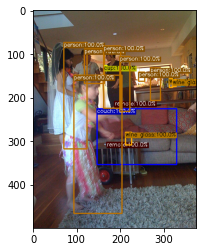

In [61]:
def test_imshow(nth: int, loader):
    """
    Displays nth validation image from the given data loader
    with bounding boxes and class labels overlaid on the image
    using the COCO_CLASSES dataset.

    :param n: Number of sample images to display.
    :type n: int
    :param loader: A PyTorch DataLoader containing the sample
        images and their targets.
    :type loader: DataLoader

    :return: None
    :rtype: NoneType
    """
    for i, (_, targets, impath, shapes) in enumerate(loader):

        # Get the bounding boxes from the targets
        boxes = targets[:, 2:]

        # Convert bounding boxes from [x, y, w, h] to [x1, y1, x2, y2]
        boxes_xyxy = xywh2xyxy(boxes.clone())

        # Check if we have reached the nth sample to display
        if (i == nth):
            break

    # Get the height and width of the image
    height, width = shapes[0]

    # Scale the bounding boxes to match the image size
    boxes_xyxy *= np.array([width, height, width, height])

    # Visualization of the annotated objects in the image
    detecetd_img = vis(img=cv2.imread(impath),
                       boxes=boxes_xyxy,
                       scores=np.ones_like(targets[:, 0]),
                       cls_ids=targets[:, 1],
                       conf=score_thr,
                       class_names=COCO_CLASSES)

    # Display the image using matplotlib
    plt.imshow(detecetd_img[:, :, ::-1])


# Showing images with annotated bboxes
test_imshow(nth=41, loader=dataloader[1])

This is the validation function, inspired from the one in `yolov7` repository, but changed it to use with `yolox`models.

In [62]:
# Defining the modified validation function for YOLOX
def yolox_test(data,
               model: Model,
               dataloader: torch.utils.data.DataLoader,
               conf_thres: float = 0.01,
               iou_thres: float = 0.65,
               single_cls: bool = False,
               v5_metric: bool = False,
               names: List[str] = None,
               num_samples: int = None):

    # Get the prediction containing key of the model
    output_blob = model.output(0)

    # Check the dataset to ensure it has the expected format
    check_dataset(data)

    # Determine the number of classes
    nc = 1 if single_cls else int(data['nc'])  # number of classes

    # Create an IoU vector for computing mAP
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    # Initialize variables for tracking evaluation statistics
    seen = 0
    p, r, mp, mr, map50, map = 0., 0., 0., 0., 0., 0.
    stats, ap, ap_class = [], [], []

    # Get the height and width of the input to the model
    _, _, h, w = model.inputs[0].shape
    output_blob = model.output(0)

    # Iterate through each batch of images in the dataloader
    for (_, targets, impath, shapes) in tqdm(dataloader):

        # Get the number of labels in the batch, amd image dimensions
        nl = len(targets)
        im_h, im_w = shapes[0]

        # Load and Preprocess the image to fit the input dimensions of
        # the model
        origin_img = notebook_utils.load_image(path=impath)
        image, ratio = preprocess(origin_img, (h, w))

        # Prepare the input tensor for the model
        prepared_img = prepare_input_tensor(image=image)

        # Disable gradient calculations
        with torch.no_grad():
            # Post-process the model's output to get the predictions
            res = model(prepared_img)[output_blob]

        # Post-process the model's output to get the predictions
        predictions = demo_postprocess(outputs=res, img_size=(h, w))[0]

        ### Prediction
        # Extract bounding boxes and confidence scores from the predictions
        boxes = predictions[:, :4]
        scores = predictions[:, 4, None] * predictions[:, 5:]

        # Convert the bounding boxes to the format (x1, y1, x2, y2) and adjust
        # for the image's aspect ratio
        boxes_xyxy = xywh2xyxy(boxes)
        boxes_xyxy /= ratio

        # Apply non-maximum suppression to get the final set of predictions
        dets = multiclass_nms(boxes=boxes_xyxy,
                              scores=scores,
                              nms_thr=iou_thres,
                              score_thr=conf_thres)

        # If there are no detections, skip this image
        if dets is None:
            print(f"No detection at {impath}")
            continue

        # Extract the predicted bounding boxes, confidence scores, and class
        # labels from the detections
        pred_boxes_xyxy = torch.tensor(dets[:, :4])
        pred_conf = torch.tensor(dets[:, 4])
        pred_cls = torch.tensor(dets[:, 5])

        # Assign all predictions as incorrect
        correct = torch.zeros(dets.shape[0],
                              niou,
                              dtype=torch.bool,
                              device='cpu')

        ### Truths

        # Extract ground truth class and bounding box coordinates
        gt_cls = targets[:, 1]
        gt_boxes = targets[:, 2:]

        # Convert bounding box coordinates from (x, y, w, h) format to
        # (x1, y1, x2, y2) format and scale according to image size
        gt_boxes_xyxy = xywh2xyxy(gt_boxes) * \
            np.array([im_w, im_h, im_w, im_h])

        # Initialize an empty list to store the detected bounding boxes
        detected = []

        # Loop over unique ground truth classes
        for cls in torch.unique(gt_cls):

            # Find the indices of the ground truth and prediction boxes that
            # belong to the current class
            ti = (cls == gt_cls).nonzero(as_tuple=False).view(-1)
            pi = (cls == pred_cls).nonzero(as_tuple=False).view(-1)

            # If there are predicted boxes that belong to the current class
            if pi.shape[0]:

                # Compute the intersection over union (IoU) between the
                # predicted and ground truth boxes and select best ones
                ious, i = box_iou(pred_boxes_xyxy[pi],
                                  gt_boxes_xyxy[ti]).max(1)

                # Append the detected ground truth boxes to the `detected` list
                detected_set = set()
                for j in (ious > iouv[0]).nonzero(as_tuple=False):
                    # Detected Target
                    d = ti[i[j]]
                    if d.item() not in detected_set:
                        detected_set.add(d.item())
                        detected.append(d)
                        correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn

                        # If all ground truth boxes have been detected, break
                        # out of the loop
                        if len(detected) == nl:
                            break
        # Append the results for the current image to the `stats` list
        stats.append((correct.cpu(), pred_conf.cpu(), pred_cls.cpu(), gt_cls))

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy

    if len(stats) and stats[0].any():

        # Compute the average precision (AP) per class
        p, r, ap, f1, ap_class = ap_per_class(*stats,
                                              plot=False,
                                              v5_metric=v5_metric,
                                              names=names)

        # Compute the AP at IoU threshold 0.5 and the mean AP over all IoU
        # thresholds from 0.5 to 0.95
        ap50, ap = ap[:, 0], ap.mean(1)

        # Compute the mean precision, mean recall, mean AP at IoU threshold
        # 0.5, and mean AP over all IoU thresholds from 0.5 to 0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()

        # Compute the number of targets per class
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)

    else:

        # If no detections were made, set the number of targets to 0
        nt = torch.zeros(1)

    # Compute the mean AP for each class
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]

    # Return the mean precision, mean recall, mean AP at IoU threshold 0.5,
    # mean AP over all IoU thresholds from 0.5 to 0.95,
    return mp, mr, map50, map, maps, seen, nt.sum()


The `yolox_test` validation function reports following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects.
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t - mean average precision`, represented as area under the Precision-Recall curve agregated over all classes in dataset, where t is Intersection Over Union (IOU) threshold, degree of overlaping between ground truth and predicted objects. So, mAP@.5 means that mean average precision calculated at 0.5 IOU threshold, mAP@.5:.95 - calculated on range IOU threshlods from 0.5 to 0.95 with step 0.05.


In [64]:
# Run yolox test
mp, mr, map50, map, maps, num_images, labels = yolox_test(
    data=data, model=exec_net, dataloader=dataloader[1], names=COCO_CLASSES)

# Print calculated result
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision',
                             'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4
print(pf % ('all', num_images, labels, mp, mr, map50, map))

  0%|          | 0/5000 [00:00<?, ?it/s]

No detection at coco/images/val2017/000000173183.jpg
No detection at coco/images/val2017/000000267946.jpg
No detection at coco/images/val2017/000000268996.jpg
No detection at coco/images/val2017/000000374727.jpg
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all           0       36335       0.419        0.23       0.206      0.0597
